# Time Series Style Transfer

In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed
from dataset.tf_pipeline import make_train_valid_dset
from datetime import datetime
import io
import json
import os
from utils.metric import signature_on_batch, signature_metric
import mlflow

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [57]:
config = Proposed()
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

CONTENT_DATASET_PATH = "data/simulated_dataset/01 - Source Domain.h5"
STYLE_DATASET_PATHS = ["data/simulated_dataset/output_noise/0.25.h5", "data/simulated_dataset/output_noise/0.75.h5"]

EXPERIMENT_NAME = f"{date_str} - Style Transfer Algorithm"
SAVE_FOLDER = f"experiments_logs/{EXPERIMENT_NAME}"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = config.batch_size
EPOCHS = 15# config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
N_SIGNAL= 7

STYLE_VECTOR_SIZE = 16
FEAT_WIENER = 2
N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_VALIDATION_SEQUENCE = 500

L_STYLE_GENERATION= 0.01
L_RECONSTR= 0.1

L_CONTENT= 1
L_DIS= 0
TRIPLET_R = 1
L_TRIPLET= 1
L_REALNESS= 1
L_ADV= 1


BASE_DIR = f"logs/{EXPERIMENT_NAME}"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/train"
VALID_LOGS_DIR_PATH = f"{BASE_DIR}/valid"
GENERATION_LOG = f"{BASE_DIR}/Generations"
os.makedirs(GENERATION_LOG)
os.makedirs(SAVE_FOLDER)

In [58]:
# server_ip = "192.168.210.102"
# mlflow_port_number= "5001"

# mlflow.set_tracking_uri(f'http://{server_ip}:{mlflow_port_number}') 
# exp = mlflow.get_experiment_by_name("Style Transfer Algorithm")

# run = mlflow.start_run(run_name=date_str) 
# mlflow.tensorflow.autolog()



In [59]:
def save_configuration():
    d = {
        "content_dataset":CONTENT_DATASET_PATH,
        "style_datasets":STYLE_DATASET_PATHS,
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "n_validation_sequence":N_VALIDATION_SEQUENCE,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,    
        "log_dir":BASE_DIR
    }

    json_object = json.dumps(d)
    mlflow.log_params({
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,
    })

    with open(f"{SAVE_FOLDER}/parameters.json", "w") as outfile:
        outfile.write(json_object)


save_configuration()

# Load the Datasets

In [60]:
def train_valid_split(df, train_size:float=.7):
    dset_size = df.shape[0]
    train_index = int(dset_size* train_size)

    train_split = df.loc[:train_index]
    valid_split = df.loc[train_index:]

    return train_split, valid_split

In [61]:
def pd_to_tf_dset(df_path:str):
    _df= pd.read_hdf(df_path).astype(np.float32)
    _df = _df.drop(columns=['labels'])

    content_train, content_valid = make_train_valid_dset(
        _df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        reduce_train_set=True
    )

    return content_train, content_valid


def make_style_dataset():
    style_train_datasets, style_valid_datasets = [], []

    for s_i, style_path in enumerate(STYLE_DATASET_PATHS):
        dset_style_train, dset_style_valid = pd_to_tf_dset(style_path)

        dset_style_train = dset_style_train.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()
        dset_style_valid = dset_style_valid.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()

        dset_style_train = dset_style_train.unbatch()
        dset_style_valid = dset_style_valid.unbatch()
    
        style_train_datasets.append(dset_style_train)
        style_valid_datasets.append(dset_style_valid)

    style_dset_train = tf.data.Dataset.sample_from_datasets(style_train_datasets).batch(BS, drop_remainder=True)
    style_dset_valid = tf.data.Dataset.sample_from_datasets(style_valid_datasets).batch(BS, drop_remainder=True)

    return style_dset_train, style_dset_valid


In [62]:
content_dset_train, content_dset_valid = pd_to_tf_dset(CONTENT_DATASET_PATH)
style_dset_train, style_dset_valid = make_style_dataset()

[+] Reducing Train set size...
[+] Reducing Train set size...


[+] Reducing Train set size...


## Make Content Encoder

In [63]:
# Define AdaIN Layers for Time Series
class AdaIN(tf.keras.layers.Layer):
    def __init__(self):
        super(AdaIN, self).__init__()

    def get_mean_std(self, x, eps=1e-5):
        _mean, _variance = tf.nn.moments(x, axes=[1], keepdims=True)
        standard_dev = tf.sqrt(_variance+ eps)
        return _mean, standard_dev

    def call(self, content_input, style_input):
        # print(content_input.shape, style_input.shape)
        content_mean, content_std = self.get_mean_std(content_input)
        style_mean, style_std = self.get_mean_std(style_input)
        adain_res =style_std* (content_input - content_mean) / content_std+ style_mean
        return adain_res

In [64]:
def make_content_encoder(seq_length:int, n_feat:int, feat_wiener:int):
    _input = tf.keras.Input((seq_length, n_feat,))

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(_input)
    # x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(feat_wiener, 5, 1, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model(_input, x)

    return model

def make_style_encoder(seq_length:int, n_feat:int, vector_output_shape:int):
    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same')(_input)    
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(x)
    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same')(x)
    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same')(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.Dense(50)(x)
    x = tf.keras.layers.Dense(vector_output_shape)(x)

    model = tf.keras.Model(_input, x)
    return model

def make_decoder(n_sample_wiener:int, feat_wiener:int, style_vector_size:int, out_feat:int):
    _content_input = tf.keras.Input((n_sample_wiener, feat_wiener))
    _style_input = tf.keras.Input((style_vector_size, 1)) 
    _style_input = tf.keras.layers.Flatten()(_style_input)

    stage_1_style = tf.keras.layers.Dense(16, name='1')(_style_input)
    stage_1_style = tf.keras.layers.Reshape((16, 1))(stage_1_style)

    stage_2_style = tf.keras.layers.Dense(32, name='2')(_style_input)
    stage_2_style = tf.keras.layers.Reshape((32, 1))(stage_2_style)

    x = AdaIN()(_content_input, stage_1_style)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same')(x)
    # x = AdaIN()(x, stage_1_style)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same')(x)
    # x = AdaIN()(x, stage_1_style)
    x = tf.keras.layers.Conv1DTranspose(256, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = AdaIN()(x, stage_2_style)
    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same')(x)
    # x = AdaIN()(x, stage_2_style)
    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same')(x)
    # x = AdaIN()(x, stage_2_style)
    x = tf.keras.layers.Conv1DTranspose(out_feat, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model([_content_input, _style_input], x)
    return model

def make_multitask_discriminator(seq_length:int, n_feat:int, n_style_class:int):
    _input = tf.keras.Input((seq_length, n_feat))
    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same')(_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv1D(64, 3, 1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv1D(128, 3, 1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)

    flattened = tf.keras.layers.Flatten()(x)
    _realness_output = tf.keras.layers.Dense(32, activation="relu")(flattened)
    # _realness_output = tf.keras.layers.Dense(32, activation="relu")(_realness_output)
    _realness_output = tf.keras.layers.Dense(1)(_realness_output)

    _style_recognition_output = tf.keras.layers.Dense(n_style_class, activation='softmax')(flattened)

    model = tf.keras.Model(_input, [_realness_output, _style_recognition_output])

    return model

In [65]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
# content_encoder.summary()

In [66]:
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
style_encoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 7)]           0         
                                                                 
 conv1d_52 (Conv1D)          (None, 32, 64)            2304      
                                                                 
 conv1d_53 (Conv1D)          (None, 32, 128)           41088     
                                                                 
 conv1d_54 (Conv1D)          (None, 32, 128)           82048     
                                                                 
 conv1d_55 (Conv1D)          (None, 16, 128)           82048     
                                                                 
 conv1d_56 (Conv1D)          (None, 16, 256)           164096    
                                                                 
 conv1d_57 (Conv1D)          (None, 16, 256)           327

In [67]:
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE, N_SIGNAL)
# decoder.summary()

In [68]:
global_discriminator = make_multitask_discriminator(SEQUENCE_LENGTH, N_SIGNAL, n_style_class=2)

In [69]:
def generate(content_batch, style_batch):
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    return generated

In [70]:
valid_seed_content = next(iter(content_dset_valid))
valid_seed_style, valid_seed_style_label = next(iter(style_dset_valid))

train_seed_content = next(iter(content_dset_train))
train_seed_style, train_seed_style_label = next(iter(style_dset_valid))

generated_sequence = generate(valid_seed_content, valid_seed_style)

2024-05-29 14:42:56.605036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:42:56.606370: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:42:57.014789: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


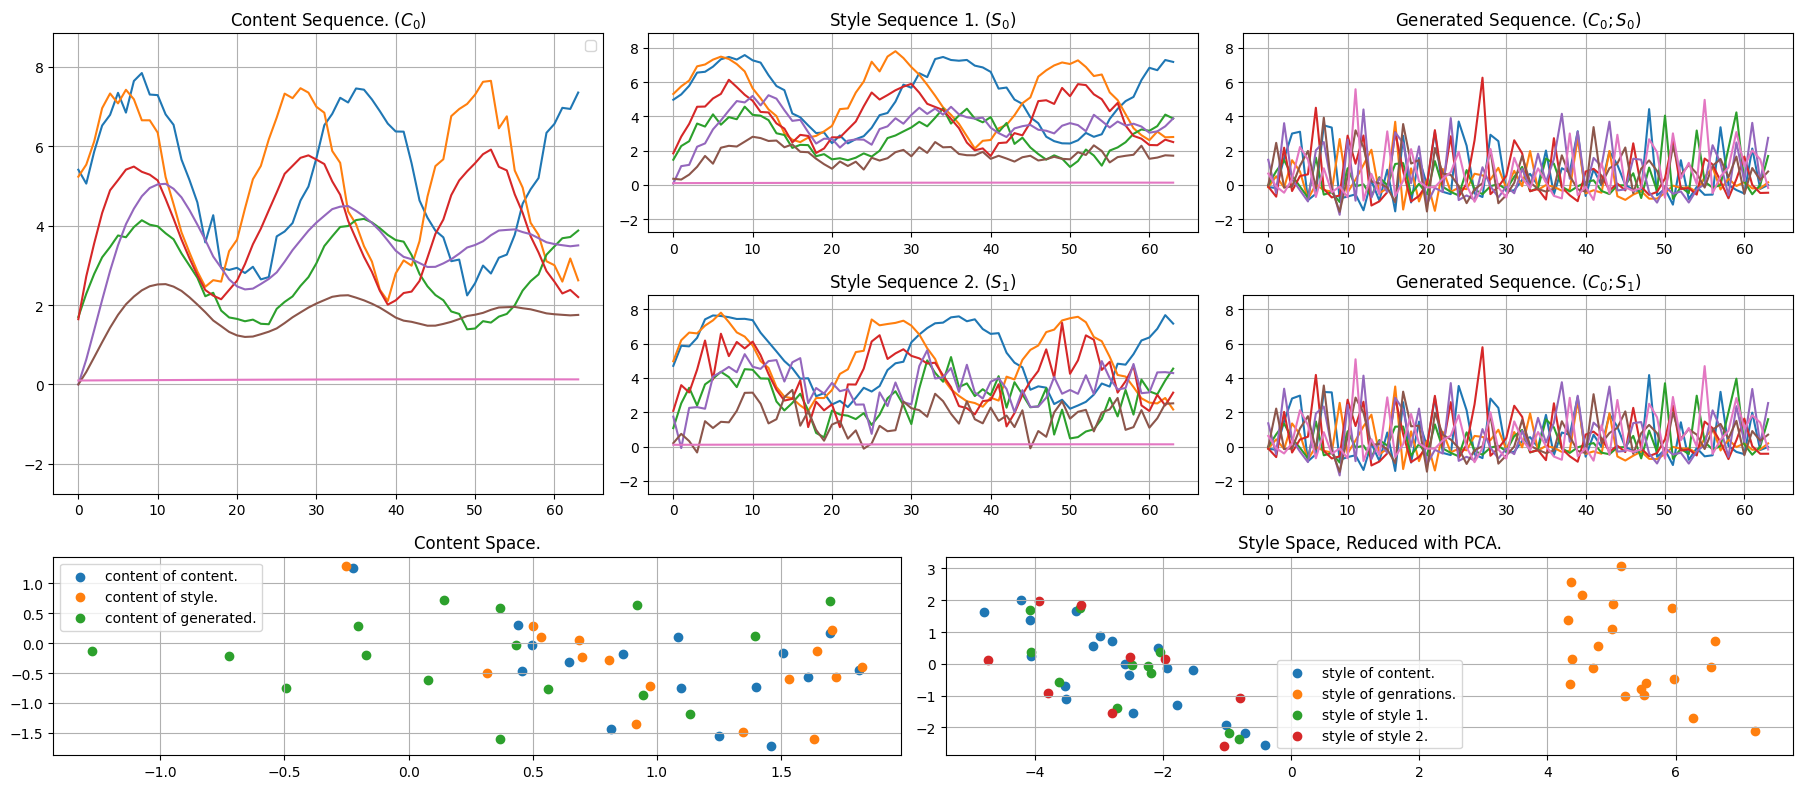

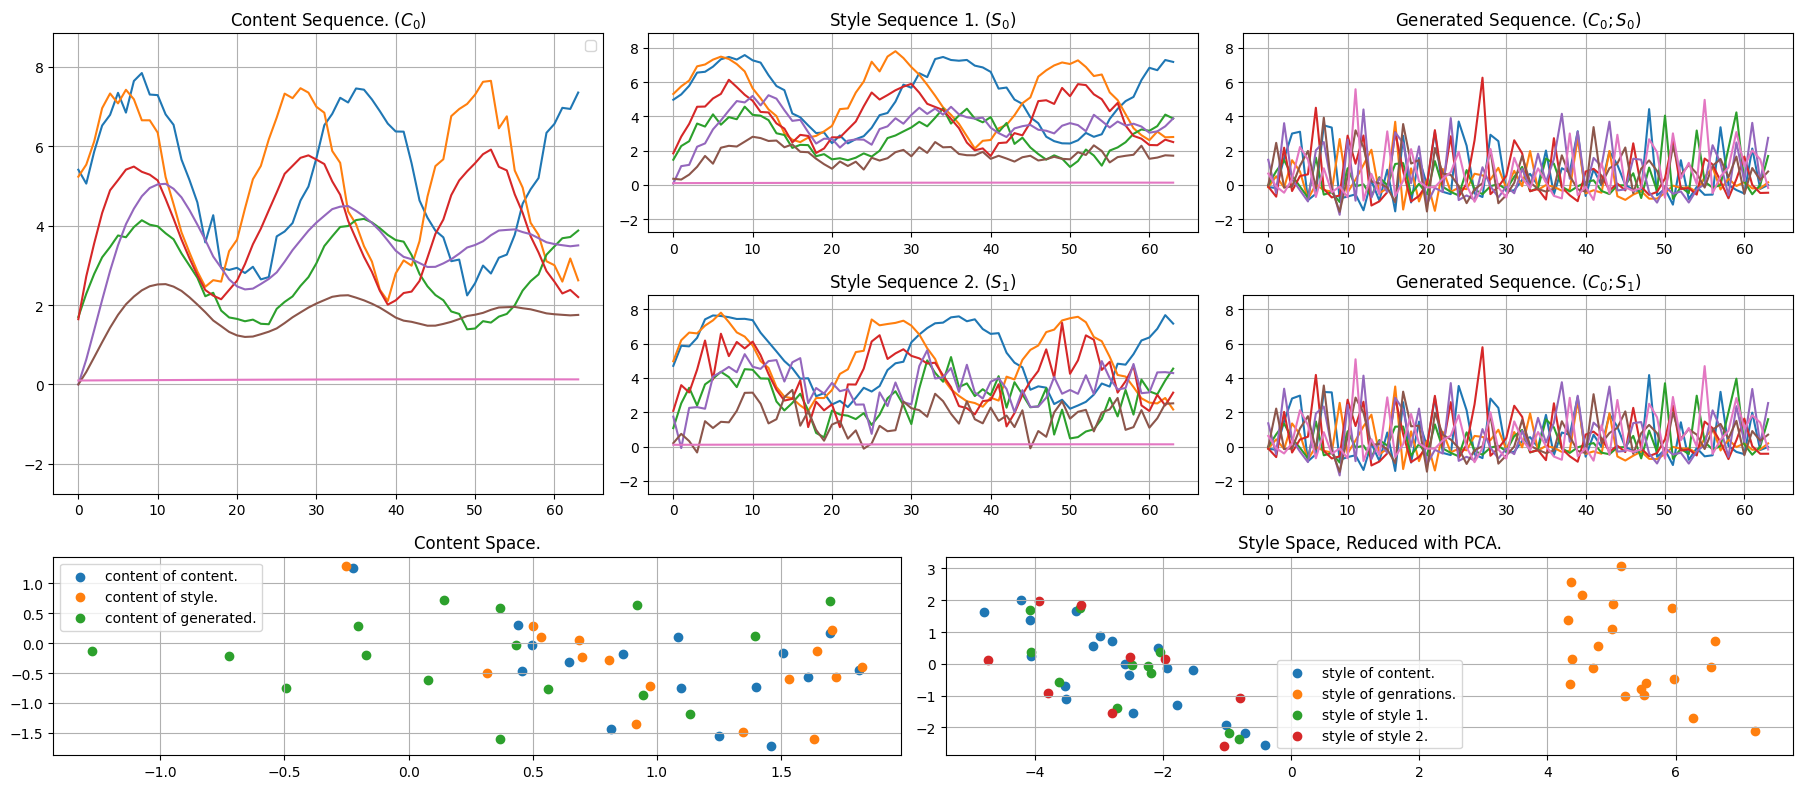

In [71]:
from sklearn.decomposition import PCA

def plot_generated_sequence2(content_sequences, style_sequences, style_labels, show=False):
    
    style_1_sequence = style_sequences[style_labels == 0][0]
    style_2_sequence = style_sequences[style_labels == 1][0]
    content_sequence_for_model = tf.gather(content_sequences, [0, 0])
    style_for_the_model = tf.stack([style_1_sequence, style_2_sequence])

    # Make Generated sequence for visualization.
    content_of_content = content_encoder(content_sequence_for_model, training=False)
    style_of_style= style_encoder(style_for_the_model, training=False)
    generated_sequences = decoder([content_of_content, style_of_style], training=False)


    # Make the computation for the scatter plots 
    content_of_style = content_encoder(style_sequences, training=False)
    style_of_style = style_encoder(style_sequences, training=False)

    content_of_content = content_encoder(content_sequences, training=False)
    style_of_content = style_encoder(content_sequences, training=False)

    generations = decoder([content_of_content, style_of_style], training=False)

    content_of_generated = content_encoder(generations, training=False)
    style_of_generated = style_encoder(generations, training=False)

    # Reduce the Style Vector for visualization purposes.
    pca = PCA(2)
    style_vectors = np.vstack([style_of_content, style_of_style, style_of_generated])

    pca.fit(style_vectors)

    reduced_style_content=pca.transform(style_of_content)
    reduced_style_generations=pca.transform(style_of_generated)
    reduced_style_style = pca.transform(style_of_style)

    reduced_style1 = reduced_style_style[style_labels == 0, :]
    reduced_style2 = reduced_style_style[style_labels == 1, :]

    all_values = np.array([content_sequence_for_model, style_for_the_model, generated_sequences])
    _min, _max = np.min(all_values)-1, np.max(all_values)+ 1

    fig= plt.figure(figsize=(18, 8))
    spec= fig.add_gridspec(3, 6)

    ax00 = fig.add_subplot(spec[0:2, :2])
    ax00.set_title('Content Sequence. ($C_0$)')
    ax00.plot(content_sequence_for_model[0])
    ax00.set_ylim(_min, _max)
    ax00.grid(True)
    ax00.legend()

# #######
    ax01 = fig.add_subplot(spec[0, 2:4])
    ax01.set_title('Style Sequence 1. ($S_0$)')
    ax01.plot(style_1_sequence)
    ax01.set_ylim(_min, _max)
    ax01.grid(True)

    ax11 = fig.add_subplot(spec[1, 2:4])
    ax11.set_title("Style Sequence 2. ($S_1$)")
    ax11.plot(style_2_sequence)
    ax11.set_ylim(_min, _max)
    ax11.grid(True)

# #######
    ax02 = fig.add_subplot(spec[0, 4:])
    ax02.set_title('Generated Sequence. ($C_0; S_0$)')
    ax02.plot(generated_sequences[0, :])
    ax02.set_ylim(_min, _max)
    ax02.grid(True) 

    ax12 = fig.add_subplot(spec[1, 4:])
    ax12.set_title('Generated Sequence. ($C_0; S_1$)')
    ax12.plot(generated_sequences[1, :])
    ax12.set_ylim(_min, _max)
    ax12.grid(True) 

# #####
    ax10 = fig.add_subplot(spec[2, :3])
    ax10.set_title('Content Space.')
    ax10.scatter(content_of_content[0, :, 0], content_of_content[0, :, 1],  label='content of content.')
    ax10.scatter(content_of_style[0, :, 0], content_of_style[0, :, 1], label='content of style.')
    ax10.scatter(content_of_generated[0, :, 0], content_of_generated[0, :, 1],  label='content of generated.')
    ax10.grid(True)
    ax10.legend()

    ax11 = fig.add_subplot(spec[2, 3:])
    ax11.set_title('Style Space, Reduced with PCA.')
    ax11.scatter(reduced_style_content[:, 0], reduced_style_content[:, 1], label='style of content.')
    ax11.scatter(reduced_style_generations[:, 0], reduced_style_generations[:, 1], label='style of genrations.')

    ax11.scatter(reduced_style1[:, 0], reduced_style1[:, 1], label='style of style 1.')
    ax11.scatter(reduced_style2[:, 0], reduced_style2[:, 1], label='style of style 2.')

    ax11.grid(True)
    ax11.legend()

    plt.tight_layout()

    return fig

plot_generated_sequence2(valid_seed_content, valid_seed_style, valid_seed_style_label)

In [72]:
def fig_to_buff(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf

## Define losses.

In [73]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()


def recontruction_loss(true:tf.Tensor, generated:tf.Tensor):
    diff = generated- true
    result = tf.math.reduce_mean(tf.square(diff))
    return result

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = encoded_content_fake- encoded_content_real
    return tf.reduce_mean(tf.square(diff))

def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)

## Tensorboard Logs.

In [74]:
# Train Metrics
# Generator Losses
met_generator_train = tf.keras.metrics.Mean(name="Total Generator Loss")
met_generator_reconstr_from_content_train= tf.keras.metrics.Mean(name="Reconstruction from Content")
met_generator_realness_train= tf.keras.metrics.Mean(name="Realness of Generations")

# Style Encoder Loss
met_triplet_train = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_train = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_train = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_train= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Correlation Metric
met_correlation_metric_train = tf.keras.metrics.Mean(name="Correlation Metric")

# Discriminator Loss
met_disc_loss_train= tf.keras.metrics.Mean(name="Discriminator Loss")
met_style_classif_on_real_train = tf.keras.metrics.Mean(name="Style Classification Loss on Real Sequences")
met_style_classif_on_gen_train = tf.keras.metrics.Mean(name="Style Classification Loss on Generated Sequences")

# Style of Reconstruction (ajouté ici mais plus un bout de scotch qu'autre chose...).
met_style_reconstruction = tf.keras.metrics.Mean(name="Style Reconstruction")

# Correlation Metric
met_correlation_metric_train = tf.keras.metrics.Mean(name="Correlation Metric")


# Valid Metrics
# Generator Metric
met_generator_valid = tf.keras.metrics.Mean(name="Total Generator Loss")
met_generator_reconstr_from_content_valid= tf.keras.metrics.Mean(name="Reconstruction from Content")
met_generator_realness_valid= tf.keras.metrics.Mean(name="Realness of Generations")

# Style encoder Loss
met_triplet_valid = tf.keras.metrics.Mean(name="Triplet Loss")
met_disentanglement_valid = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_valid = tf.keras.metrics.Mean(name="Style Loss")

# Content Encoder Loss
met_content_encoder_valid= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Discriminator Loss
met_disc_loss_valid= tf.keras.metrics.Mean(name="Discriminator Loss")
met_style_classif_on_real_valid = tf.keras.metrics.Mean(name="Style Classification Loss on Real Sequences")
met_style_classif_on_gen_valid = tf.keras.metrics.Mean(name="Style Classification Loss on Generated Sequences")

# correlation Metric
met_correlation_metric_valid = tf.keras.metrics.Mean(name="Correlation Metric")

# Style of Reconstruction (ajouté ici mais plus un bout de scotch qu'autre chose...).
met_style_reconstruction_valid = tf.keras.metrics.Mean(name="Style Reconstruction")

In [75]:
TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)
VALID_SUMMARY_WRITER = tf.summary.create_file_writer(VALID_LOGS_DIR_PATH)

def log_train_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Total Generator Loss", met_generator_train.result(), step=epoch)
        tf.summary.scalar("01 - Reconstruction from Content", met_generator_reconstr_from_content_train.result(), step=epoch)
        tf.summary.scalar("02 - Realness Loss", met_generator_realness_train.result(), step=epoch)

        tf.summary.scalar("10 - Style Loss", met_style_encoder_train.result(), step=epoch)
        tf.summary.scalar("11 - Triplet Loss", met_triplet_train.result(), step=epoch)
        tf.summary.scalar("12 - Disentanglement Loss", met_disentanglement_train.result(), step=epoch)

        tf.summary.scalar("20 - Content Loss", met_content_encoder_train.result(), step=epoch)

        tf.summary.scalar("30 - Discriminator Loss", met_disc_loss_train.result(), step=epoch)
        tf.summary.scalar("31 - Style Classification on Real", met_style_classif_on_real_train.result(), step=epoch)
        tf.summary.scalar("32 - Style Classification on Generated", met_style_classif_on_gen_train.result(), step=epoch)

        tf.summary.scalar("40 - Correlation Metric", met_correlation_metric_train.result(), step=epoch)
        
        tf.summary.image("Training Generations", image, step=epoch)


def log_valid_losses(epoch):
    with VALID_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Total Generator Loss", met_generator_valid.result(), step=epoch)
        tf.summary.scalar("01 - Reconstruction from Content", met_generator_reconstr_from_content_valid.result(), step=epoch)
        tf.summary.scalar("02 - Realness Loss", met_generator_realness_valid.result(), step=epoch)

        tf.summary.scalar("10 - Style Loss", met_style_encoder_valid.result(), step=epoch)
        tf.summary.scalar("11 - Triplet Loss", met_triplet_valid.result(), step=epoch)
        tf.summary.scalar("12 - Disentanglement Loss", met_disentanglement_valid.result(), step=epoch)

        tf.summary.scalar("20 - Content Loss", met_content_encoder_valid.result(), step=epoch)

        tf.summary.scalar("30 - Discriminator Loss", met_disc_loss_valid.result(), step=epoch)
        tf.summary.scalar("31 - Style Classification on Real", met_style_classif_on_real_valid.result(), step=epoch)
        tf.summary.scalar("32 - Style Classification on Generated", met_style_classif_on_gen_valid.result(), step=epoch)

        tf.summary.scalar("40 - Correlation Metric", met_correlation_metric_valid.result(), step=epoch)
        


def reset_metric_states():
    met_generator_train.reset_states()
    met_generator_reconstr_from_content_train.reset_states()
    met_generator_realness_train.reset_states()
    met_triplet_train.reset_states()
    met_disentanglement_train.reset_states()
    met_style_encoder_train.reset_states()
    met_content_encoder_train.reset_states()
    met_correlation_metric_train.reset_states()
    met_disc_loss_train.reset_states()
    met_style_reconstruction.reset_states()
    met_correlation_metric_train.reset_states()
    met_style_classif_on_real_train.reset_states()
    met_style_classif_on_gen_train.reset_states()


def reset_valid_states():
    met_generator_valid.reset_states()
    met_generator_reconstr_from_content_valid.reset_states()
    met_generator_realness_valid.reset_states()
    met_triplet_valid.reset_states()
    met_disentanglement_valid.reset_states()
    met_style_encoder_valid.reset_states()
    met_content_encoder_valid.reset_states()
    met_correlation_metric_valid.reset_states()
    met_disc_loss_valid.reset_states()
    met_style_reconstruction.reset_states()
    met_correlation_metric_valid.reset_states()
    met_style_classif_on_real_valid.reset_states()
    met_style_classif_on_gen_valid.reset_states()


## Instantiate model for training.

In [76]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,N_SIGNAL)


# opt_content_encoder = tf.keras.optimizers.Adam()
# opt_style_encoder = tf.keras.optimizers.Adam()
# opt_decoder = tf.keras.optimizers.Adam()
# opt_discr = tf.keras.optimizers.Adam()

opt_content_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
opt_style_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
opt_decoder = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
opt_discr = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

## Train the model

In [77]:
from itertools import product
indexes = np.array(list(product(range(BS), range(BS))))
other_index = np.arange(BS)* BS

In [78]:
anchor_indexes = np.array([ i* BS+i for i in range(BS) for _ in range(BS) ])
pos_indexes = np.array([ BS*j + i for i in range(BS) for j in range(BS)])
neg_indexes = np.array([ (j*BS + (i+1)%BS) for i in range(BS) for j in range(BS)])

In [79]:
def get_style_voctor_for_dis_loss(style_vector:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    return tf.gather(style_vector, anchor_indexes)

def get_anchor_positive_negative_from_batch(style_from_style_ts:tf.Tensor, style_of_generations:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size)])
    neg_indexes = np.array([ (j*batch_size + (i+1)%batch_size) for i in range(batch_size) for j in range(batch_size)])

    # Anchor are for example:
    # [(c0, s0), (c0, s0), 
    # (c1, s1), (c1, s1), ...]
    anchors = tf.gather(style_from_style_ts, anchor_indexes)
    # Different content, Same Style:
    # [(c1, s0), (c2, s0),(c2, s0),
    #  (c1, s1), (c2, s1), (c3, s1)...]
    # E_s(G(x, y1))
    pos_vector= tf.gather(style_of_generations, pos_indexes)
    # Same content but different style
    # [(c1, s1), (c2, s1),(c2, s1),
    #  (c1, s2), (c2, s2), (c3, s2)...]
    # # E_s(G(x, y2)) 
    neg_vector = tf.gather(style_of_generations, neg_indexes)

    return anchors, pos_vector, neg_vector

def get_dissantanglement_loss_component(style_of_generations, style_of_style, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])

    es_y = tf.gather(style_of_style, anchor_indexes)
    es_x1_y = tf.gather(style_of_generations, anchor_indexes)
    es_x2_y = tf.gather(style_of_generations, pos_indexes)

    return es_y, es_x1_y, es_x2_y


def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(y- x)
    _distance = tf.reduce_sum(diff, axis=-1)
    return _distance


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = l2(encoded_content_real, encoded_content_fake)
    return tf.reduce_mean(tf.square(diff))

def fixed_point_triplet_style_loss(anchor_encoded_style, positive_encoded_style, negative_encoded_style):
    # shape: [BS, Style_length]
    negative_distance = l2(negative_encoded_style, anchor_encoded_style)
    positive_distance = l2(positive_encoded_style, anchor_encoded_style)

    triplet = TRIPLET_R+ positive_distance- negative_distance
    zeros = tf.zeros_like(triplet)
    triplet = tf.math.maximum(triplet, zeros)

    loss = tf.reduce_mean(triplet)
    return loss

def fixed_point_disentanglement(
        es_x1_y:tf.Tensor, 
        es_x2_y:tf.Tensor, 
        es_y:tf.Tensor
        ):

    diff1 = l2(es_x1_y, es_x2_y)
    diff2 = l2(es_x1_y, es_y)

    loss = diff1- diff2
    zeros = tf.zeros_like(loss)
    loss = tf.math.maximum(loss, zeros)
    loss = tf.reduce_mean(loss)
    return loss


def style_constrain_loss(style_of_style_batch, style_of_generation):
    diff = l2(style_of_style_batch, style_of_generation)
    diff = tf.reduce_mean(diff)
    return diff

In [80]:
def _pairwise_distance(a_embeddings, b_embeddings):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(a_embeddings, tf.transpose(b_embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances

def get_positives(labels):
    # will assign 1 where this is a positive 
    positive_mask = np.array([ tf.cast(labels == l, tf.float32) for l in labels])
    positive_mask = positive_mask - np.identity(positive_mask.shape[0])
    return positive_mask

def get_negative(labels):
    neg_labels= np.array([ tf.cast(labels != l, tf.float32) for l in labels])
    return neg_labels


def get_triplet_loss(anchor_embedding, positive_embedding, negative_embedding):
    positive_distance= _pairwise_distance(anchor_embedding, positive_embedding)
    negative_distance= _pairwise_distance(anchor_embedding, negative_embedding)

    positive_index= tf.argmax(positive_distance, axis=1)

    pos_embedding = tf.gather(positive_embedding, positive_index)
 
    neg_indexes = tf.argmin(negative_distance, axis=1)
    
    neg_embeddings= tf.gather(negative_embedding, neg_indexes)

    positive_distances= l2(anchor_embedding, pos_embedding)
    negative_distances= l2(anchor_embedding, neg_embeddings)

    loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))

    return loss

In [81]:
# @tf.function
def train_step(content_batch:tf.Tensor, style_batch:tf.Tensor, style_labels:tf.Tensor):
    lambda_style_generations = L_STYLE_GENERATION
    lambda_reconstr= L_RECONSTR
    lambda_realness= L_REALNESS
    lambda_adv= L_ADV
    lambda_content= L_CONTENT
    lambda_triplet= L_TRIPLET
    lambda_dis= L_DIS
    lambda_classif_on_fake= 1

    with tf.GradientTape() as content_tape, tf.GradientTape() as style_tape, tf.GradientTape() as decoder_tape, tf.GradientTape() as discr_tape:
        extended_content_sequences = tf.gather(content_batch, indexes[:, 0])
        extended_style_sequences = tf.gather(style_batch, indexes[:, 1])
        extended_labels = tf.gather(style_labels, indexes[:, 1])
        
        # Get the content form the content batch
        c = content_encoder(extended_content_sequences, training=True)
        # Get the Style from the style batch
        s = style_encoder(extended_style_sequences, training=True)

        # Generate the time series given the content and the style.
        # Here we have (c_0, s_0), (c_0, s_1), (c_0, s_2)...
        c_s = decoder([c, s], training=True)

        # Get the content and style form generated data
        c_s_c = content_encoder(c_s, training=True)
        c_s_s = style_encoder(c_s, training=True)

        # Get content image stylized with a image from the style batch
        # E.g.  (c1, s1), (c2, s2)... (cn, sn)
        crit_on_fake, classif_on_fake = global_discriminator(c_s, training=True)
        crit_on_real, classif_on_real_content = global_discriminator(content_batch, training=True)
        _, classif_on_real_style = global_discriminator(style_batch, training=True)
        
        # Compute the generator loss 
        reconstr_from_content = recontruction_loss(extended_content_sequences, c_s)
        realness = generator_loss(crit_on_fake)
        content_similarity = fixed_point_content(c, c_s_c)

        global_dicriminator_loss = discriminator_loss(crit_on_real, crit_on_fake)
        global_classification_loss_fake = style_classsification_loss(classif_on_fake, extended_labels)

        global_classification_loss_real = style_classsification_loss(classif_on_real_content, style_labels)+\
                                          style_classsification_loss(classif_on_real_style, style_labels)
        global_classification_loss_real /= 2

        # Preparing vectors for the Fixed Point Disentanglement loss.
        s_0 = s[(indexes[:, 0] == 0) & (extended_labels == 0)]
        s_c0s0 = c_s_s[(indexes[:, 0] == 0) & (extended_labels == 0)]
        s_c1s0 = c_s_s[(indexes[:, 0] == 1) & (extended_labels == 0)]

        dis_loss = fixed_point_disentanglement(s_0, s_c0s0, s_c1s0)

        s_1 = s[(indexes[:, 0] == 0) & (extended_labels == 1)]
        s_c1s0 = c_s_s[(indexes[:, 0] == 1) & (extended_labels == 0)]
        s_c1s1 = c_s_s[(indexes[:, 0] == 1) & (extended_labels == 1)]

        # Truncate because shape are not the same.
        truncate_index = tf.reduce_min([s_1.shape[0], s_c1s0.shape[0], s_c1s1.shape[0]])
        s_1= s_1[:truncate_index]
        s_c1s0= s_c1s0[:truncate_index]
        s_c1s1= s_c1s1[:truncate_index]

        triplet_style =  get_triplet_loss(s_1, s_c1s1, s_c1s0)

        d_loss = lambda_adv* global_dicriminator_loss
        content_encoder_loss = lambda_content* content_similarity
        style_encoder_loss = lambda_triplet* triplet_style + lambda_dis* dis_loss
        g_loss = lambda_reconstr* reconstr_from_content+ lambda_realness* realness + lambda_classif_on_fake* global_classification_loss_fake

    content_grad=content_tape.gradient(content_encoder_loss, content_encoder.trainable_variables)
    style_grad = style_tape.gradient(style_encoder_loss, style_encoder.trainable_variables)
    decoder_grad = decoder_tape.gradient(g_loss, decoder.trainable_variables)
    discr_grads = discr_tape.gradient([d_loss, global_classification_loss_real], global_discriminator.trainable_variables)

    opt_content_encoder.apply_gradients(zip(content_grad, content_encoder.trainable_variables))
    opt_style_encoder.apply_gradients(zip(style_grad, style_encoder.trainable_variables))
    opt_decoder.apply_gradients(zip(decoder_grad, decoder.trainable_variables))
    opt_discr.apply_gradients(zip(discr_grads, global_discriminator.trainable_variables))

    met_generator_train(g_loss)
    met_generator_reconstr_from_content_train(reconstr_from_content)
    met_generator_realness_train(realness)

    met_style_encoder_train(style_encoder_loss)
    met_triplet_train(triplet_style)
    met_disentanglement_train(dis_loss)

    met_content_encoder_train(content_similarity)
    met_disc_loss_train(global_dicriminator_loss)
    met_style_classif_on_real_train(global_classification_loss_real)
    met_style_classif_on_gen_train(global_classification_loss_fake)





# @tf.function
def valid_step(content_batch:tf.Tensor, style_batch:tf.Tensor, style_labels:tf.Tensor):
    lambda_style_generations = L_STYLE_GENERATION
    lambda_reconstr= L_RECONSTR
    lambda_realness= L_REALNESS
    lambda_adv= L_ADV
    lambda_content= L_CONTENT
    lambda_triplet= L_TRIPLET
    lambda_dis= L_DIS
    lambda_classif_on_fake = 1
    
    extended_content_sequences = tf.gather(content_batch, indexes[:, 0])
    extended_style_sequences = tf.gather(style_batch, indexes[:, 1])
    extended_labels = tf.gather(style_labels, indexes[:, 1])
    
    # Get the content form the content batch
    c = content_encoder(extended_content_sequences, training=False)
    # Get the Style from the style batch
    s = style_encoder(extended_style_sequences, training=False)

    # Generate the time series given the content and the style.
    # Here we have (c_0, s_0), (c_0, s_1), (c_0, s_2)...
    c_s = decoder([c, s], training=False)

    # Get the content and style form generated data
    c_s_c = content_encoder(c_s, training=False)
    c_s_s = style_encoder(c_s, training=False)

    # Get content image stylized with a image from the style batch
    # E.g.  (c1, s1), (c2, s2)... (cn, sn)
    crit_on_fake, classif_on_fake = global_discriminator(c_s, training=False)
    crit_on_real, classif_on_real_content = global_discriminator(content_batch, training=False)
    _, classif_on_real_style = global_discriminator(style_batch, training=False)
    
    # Compute the generator loss 
    reconstr_from_content = recontruction_loss(extended_content_sequences, c_s)
    realness = generator_loss(crit_on_fake)
    content_similarity = fixed_point_content(c, c_s_c)

    global_dicriminator_loss = discriminator_loss(crit_on_real, crit_on_fake)
    global_classification_loss_fake = style_classsification_loss(classif_on_fake, extended_labels)

    global_classification_loss_real = style_classsification_loss(classif_on_real_content, style_labels)+\
                                      style_classsification_loss(classif_on_real_style, style_labels)
    global_classification_loss_real /= 2

    # Preparing vectors for the Fixed Point Disentanglement loss.
    s_0 = s[(indexes[:, 0] == 0) & (extended_labels == 0)]
    s_c0s0 = c_s_s[(indexes[:, 0] == 0) & (extended_labels == 0)]
    s_c1s0 = c_s_s[(indexes[:, 0] == 1) & (extended_labels == 0)]

    dis_loss = fixed_point_disentanglement(s_0, s_c0s0, s_c1s0)

    s_1 = s[(indexes[:, 0] == 0) & (extended_labels == 1)]
    s_c1s0 = c_s_s[(indexes[:, 0] == 1) & (extended_labels == 0)]
    s_c1s1 = c_s_s[(indexes[:, 0] == 1) & (extended_labels == 1)]

    # Truncate because shape are not the same.
    truncate_index = tf.reduce_min([s_1.shape[0], s_c1s0.shape[0], s_c1s1.shape[0]])
    s_1= s_1[:truncate_index]
    s_c1s0= s_c1s0[:truncate_index]
    s_c1s1= s_c1s1[:truncate_index]

    triplet_style =  get_triplet_loss(s_1, s_c1s1, s_c1s0)

    d_loss = lambda_adv* global_dicriminator_loss
    content_encoder_loss = lambda_content* content_similarity
    style_encoder_loss = lambda_triplet* triplet_style + lambda_dis* dis_loss
    g_loss = lambda_reconstr* reconstr_from_content+ lambda_realness* realness + lambda_classif_on_fake* global_classification_loss_fake

    met_generator_valid(g_loss)
    met_generator_reconstr_from_content_valid(reconstr_from_content)
    met_generator_realness_valid(realness)

    met_triplet_valid(triplet_style)
    met_disentanglement_valid(dis_loss)
    met_style_encoder_valid(style_encoder_loss)

    met_content_encoder_valid(content_encoder_loss)

    met_disc_loss_valid(d_loss)
    met_style_classif_on_real_valid(global_classification_loss_real)
    met_style_classif_on_gen_valid(global_classification_loss_fake)

In [82]:
def train():
    total_batch = "?"
    for e in range(EPOCHS):
        reset_metric_states()
        reset_valid_states()
        
        print("[+] Train Step...")
        for i, (content_batch, (style_sequences, style_labels)) in enumerate(zip(content_dset_train, style_dset_train)):
            train_step(content_batch, style_sequences, style_labels)
            print(f"\r e:{e}/{EPOCHS}; {i}/{total_batch}. \
G_loss {met_generator_train.result():0.2f} \
Triplet Loss {met_triplet_train.result():0.2f}; \
Disentanglement Loss: {met_disc_loss_train.result():0.2f}; \
Content Loss {met_content_encoder_train.result():0.2f} \
D Loss {met_disc_loss_train.result():0.2f}; \
Classif [Real; Fake]: [{met_style_classif_on_real_train.result():0.2f}; {met_style_classif_on_gen_train.result():0.2f}]        ", end="")
            # return

        print()
        print("[+] Validation Step...")
        for vb, (content_batch, (style_sequences, style_labels)) in enumerate(zip(content_dset_valid, style_dset_valid)):
            valid_step(content_batch, style_sequences, style_labels)
            print(f"\r e:{e}/{EPOCHS}; {vb}. \
G_loss {met_generator_valid.result():0.2f} \
Triplet Loss {met_triplet_valid.result():0.2f}; \
Disentanglement Loss: {met_disc_loss_train.result():0.2f}; \
Content Loss {met_content_encoder_train.result():0.2f} \
D Loss {met_disc_loss_train.result():0.2f}\
Classif [Real; Fake]: [{met_style_classif_on_real_valid.result():0.2f}; {met_style_classif_on_gen_valid.result():0.2f}]         ", end="")
    
        # Make Generations Train Set
        train_generations = generate(train_seed_content, train_seed_style)

        train_style_signature = signature_on_batch(train_seed_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
        train_generated_signature = signature_on_batch(train_generations, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
        train_signature_difference = signature_metric(train_style_signature, train_generated_signature)
        met_correlation_metric_train(train_signature_difference)


        # Make Generations Valid Set 
        valid_generations = generate(valid_seed_content, valid_seed_style)

        vis_fig = plot_generated_sequence2(valid_seed_content, valid_seed_style, valid_seed_style_label)
        plot_buff = fig_to_buff(vis_fig)
        
        # Compute the Correlation Metric on Valid set.
        valid_style_signature = signature_on_batch(valid_seed_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
        valid_generated_signature = signature_on_batch(valid_generations, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
        valid_signature_difference = signature_metric(valid_style_signature, valid_generated_signature)
        met_correlation_metric_valid(valid_signature_difference)

        print(f"\n[+] Signature Difference {valid_signature_difference:0.2f}")

        log_train_losses(e, plot_buff)
        log_valid_losses(e)
        print()

        if e == 0:
            total_batch = i 

train()

[+] Train Step...
 e:0/15; 149/?. G_loss 3998.99 Triplet Loss 130079400.00; Disentanglement Loss: 0.17; Content Loss 567008093536256.00 D Loss 0.17; Classif [Real; Fake]: [0.74; 5.20]             
[+] Validation Step...
 e:0/15; 0. G_loss 27.64 Triplet Loss 421.29; Disentanglement Loss: 0.17; Content Loss 567008093536256.00 D Loss 0.17Classif [Real; Fake]: [0.69; 1.67]         

2024-05-29 14:43:45.156009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:43:45.156337: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:0/15; 24. G_loss 24.61 Triplet Loss 870.97; Disentanglement Loss: 0.17; Content Loss 567008093536256.00 D Loss 0.17Classif [Real; Fake]: [0.68; 1.49]         

2024-05-29 14:43:47.368596: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:43:47.368670: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 1249.49

[+] Train Step...
 e:1/15; 149/149. G_loss 50.25 Triplet Loss 5130653.00; Disentanglement Loss: 0.68; Content Loss 33864096.00 D Loss 0.68; Classif [Real; Fake]: [0.70; 4.46]        
[+] Validation Step...
 e:1/15; 0. G_loss 66.08 Triplet Loss 0.00; Disentanglement Loss: 0.68; Content Loss 33864096.00 D Loss 0.68Classif [Real; Fake]: [0.64; 20.40]         

2024-05-29 14:44:31.394144: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:44:31.394604: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:1/15; 24. G_loss 63.44 Triplet Loss 7764.00; Disentanglement Loss: 0.68; Content Loss 33864096.00 D Loss 0.68Classif [Real; Fake]: [0.70; 17.69]         

2024-05-29 14:44:33.580848: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:44:33.580919: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 53994.44

[+] Train Step...
 e:2/15; 149/149. G_loss 36.72 Triplet Loss 1435.17; Disentanglement Loss: 0.50; Content Loss 2616716.50 D Loss 0.50; Classif [Real; Fake]: [0.70; 7.07]        
[+] Validation Step...
 e:2/15; 0. G_loss 17.00 Triplet Loss 133.06; Disentanglement Loss: 0.50; Content Loss 2616716.50 D Loss 0.50Classif [Real; Fake]: [0.61; 1.66]         

2024-05-29 14:45:17.824341: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:45:17.825111: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:2/15; 24. G_loss 14.44 Triplet Loss 69.55; Disentanglement Loss: 0.50; Content Loss 2616716.50 D Loss 0.50Classif [Real; Fake]: [0.62; 1.24]         

2024-05-29 14:45:20.083349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:45:20.083418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 33.60

[+] Train Step...
 e:3/15; 149/149. G_loss 152.69 Triplet Loss 715735.44; Disentanglement Loss: 0.68; Content Loss 357172384.00 D Loss 0.68; Classif [Real; Fake]: [0.65; 13.47]          
[+] Validation Step...
 e:3/15; 0. G_loss 2.75 Triplet Loss 25.09; Disentanglement Loss: 0.68; Content Loss 357172384.00 D Loss 0.68Classif [Real; Fake]: [0.68; 0.71]         

2024-05-29 14:46:03.789912: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:46:03.790386: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:3/15; 24. G_loss 2.73 Triplet Loss 28.68; Disentanglement Loss: 0.68; Content Loss 357172384.00 D Loss 0.68Classif [Real; Fake]: [0.65; 0.71]         

2024-05-29 14:46:06.071437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:46:06.071503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 102.43

[+] Train Step...
 e:4/15; 149/149. G_loss 46.34 Triplet Loss 12054.54; Disentanglement Loss: 0.77; Content Loss 111895.81 D Loss 0.77; Classif [Real; Fake]: [0.62; 10.70]        
[+] Validation Step...
 e:4/15; 0. G_loss 3.53 Triplet Loss 174.65; Disentanglement Loss: 0.77; Content Loss 111895.81 D Loss 0.77Classif [Real; Fake]: [0.54; 0.70]         

2024-05-29 14:46:49.752053: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:46:49.752548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:4/15; 24. G_loss 3.57 Triplet Loss 73.47; Disentanglement Loss: 0.77; Content Loss 111895.81 D Loss 0.77Classif [Real; Fake]: [0.57; 0.71]         

2024-05-29 14:46:51.971333: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:46:51.971404: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 16.21

[+] Train Step...
 e:5/15; 149/149. G_loss 14.41 Triplet Loss 4325.44; Disentanglement Loss: 0.63; Content Loss 185374.86 D Loss 0.63; Classif [Real; Fake]: [0.60; 2.99]        
[+] Validation Step...
 e:5/15; 0. G_loss 6.43 Triplet Loss 42.47; Disentanglement Loss: 0.63; Content Loss 185374.86 D Loss 0.63Classif [Real; Fake]: [0.49; 0.72]         

2024-05-29 14:47:36.339797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:47:36.340366: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:5/15; 24. G_loss 6.01 Triplet Loss 52.60; Disentanglement Loss: 0.63; Content Loss 185374.86 D Loss 0.63Classif [Real; Fake]: [0.53; 0.66]         

2024-05-29 14:47:38.568726: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:47:38.568793: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 896.12

[+] Train Step...
 e:6/15; 149/149. G_loss 6.27 Triplet Loss 493.21; Disentanglement Loss: 0.87; Content Loss 287.44 D Loss 0.87; Classif [Real; Fake]: [0.57; 1.66]         
[+] Validation Step...
 e:6/15; 0. G_loss 1.34 Triplet Loss 3.22; Disentanglement Loss: 0.87; Content Loss 287.44 D Loss 0.87Classif [Real; Fake]: [0.50; 0.81]         

2024-05-29 14:48:21.804482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:48:21.804976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:6/15; 24. G_loss 1.28 Triplet Loss 3.15; Disentanglement Loss: 0.87; Content Loss 287.44 D Loss 0.87Classif [Real; Fake]: [0.54; 0.85]         

2024-05-29 14:48:24.067416: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:48:24.067486: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 92.24

[+] Train Step...
 e:7/15; 149/149. G_loss 35.31 Triplet Loss 5974.74; Disentanglement Loss: 0.79; Content Loss 528241.31 D Loss 0.79; Classif [Real; Fake]: [0.57; 8.21]         
[+] Validation Step...
 e:7/15; 0. G_loss 3.35 Triplet Loss 17.40; Disentanglement Loss: 0.79; Content Loss 528241.31 D Loss 0.79Classif [Real; Fake]: [0.55; 0.85]         

2024-05-29 14:49:08.289641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:49:08.290058: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:7/15; 24. G_loss 3.30 Triplet Loss 17.28; Disentanglement Loss: 0.79; Content Loss 528241.31 D Loss 0.79Classif [Real; Fake]: [0.53; 0.79]         

2024-05-29 14:49:10.562651: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:49:10.562731: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 46.57

[+] Train Step...
 e:8/15; 149/149. G_loss 11.44 Triplet Loss 747.77; Disentanglement Loss: 0.84; Content Loss 6226.18 D Loss 0.84; Classif [Real; Fake]: [0.57; 3.00]         
[+] Validation Step...
 e:8/15; 0. G_loss 2.49 Triplet Loss 28.32; Disentanglement Loss: 0.84; Content Loss 6226.18 D Loss 0.84Classif [Real; Fake]: [0.53; 0.89]         

2024-05-29 14:49:54.388381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:49:54.388794: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:8/15; 24. G_loss 2.55 Triplet Loss 11.25; Disentanglement Loss: 0.84; Content Loss 6226.18 D Loss 0.84Classif [Real; Fake]: [0.55; 0.89]         

2024-05-29 14:49:56.689009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:49:56.689092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 15.77

[+] Train Step...
 e:9/15; 149/149. G_loss 5.76 Triplet Loss 72.34; Disentanglement Loss: 0.67; Content Loss 8.89 D Loss 0.67; Classif [Real; Fake]: [0.57; 1.08]         
[+] Validation Step...
 e:9/15; 0. G_loss 2.66 Triplet Loss 1.14; Disentanglement Loss: 0.67; Content Loss 8.89 D Loss 0.67Classif [Real; Fake]: [0.49; 0.67]         

2024-05-29 14:50:40.617284: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:50:40.618113: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:9/15; 24. G_loss 2.88 Triplet Loss 3.25; Disentanglement Loss: 0.67; Content Loss 8.89 D Loss 0.67Classif [Real; Fake]: [0.47; 0.61]         

2024-05-29 14:50:42.874635: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:50:42.874701: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 801.71

[+] Train Step...
 e:10/15; 149/149. G_loss 10.40 Triplet Loss 24.26; Disentanglement Loss: 0.70; Content Loss 117.49 D Loss 0.70; Classif [Real; Fake]: [0.65; 1.80]        
[+] Validation Step...
 e:10/15; 0. G_loss 1.57 Triplet Loss 1.88; Disentanglement Loss: 0.70; Content Loss 117.49 D Loss 0.70Classif [Real; Fake]: [0.40; 0.60]         

2024-05-29 14:51:27.139219: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:51:27.139627: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:10/15; 24. G_loss 1.56 Triplet Loss 1.70; Disentanglement Loss: 0.70; Content Loss 117.49 D Loss 0.70Classif [Real; Fake]: [0.44; 0.66]         

2024-05-29 14:51:29.356315: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:51:29.356381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 271.34

[+] Train Step...
 e:11/15; 149/149. G_loss 7.10 Triplet Loss 6.23; Disentanglement Loss: 0.37; Content Loss 4.02 D Loss 0.37; Classif [Real; Fake]: [0.53; 1.52]          
[+] Validation Step...
 e:11/15; 0. G_loss 4.20 Triplet Loss 1.08; Disentanglement Loss: 0.37; Content Loss 4.02 D Loss 0.37Classif [Real; Fake]: [0.43; 0.71]         

2024-05-29 14:52:13.219504: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:52:13.219830: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:11/15; 24. G_loss 3.89 Triplet Loss 1.21; Disentanglement Loss: 0.37; Content Loss 4.02 D Loss 0.37Classif [Real; Fake]: [0.47; 0.72]         

2024-05-29 14:52:15.472364: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:52:15.472433: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 684.37

[+] Train Step...
 e:12/15; 149/149. G_loss 8.17 Triplet Loss 10.05; Disentanglement Loss: 0.29; Content Loss 2.20 D Loss 0.29; Classif [Real; Fake]: [0.49; 1.57]          
[+] Validation Step...
 e:12/15; 0. G_loss 7.18 Triplet Loss 1.16; Disentanglement Loss: 0.29; Content Loss 2.20 D Loss 0.29Classif [Real; Fake]: [0.39; 0.73]         

2024-05-29 14:52:59.502489: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:52:59.502863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:12/15; 24. G_loss 7.01 Triplet Loss 1.45; Disentanglement Loss: 0.29; Content Loss 2.20 D Loss 0.29Classif [Real; Fake]: [0.41; 0.72]         

2024-05-29 14:53:01.708519: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:53:01.708583: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 388.79

[+] Train Step...
 e:13/15; 149/149. G_loss 10.38 Triplet Loss 5.38; Disentanglement Loss: 0.24; Content Loss 0.69 D Loss 0.24; Classif [Real; Fake]: [0.48; 1.91]        
[+] Validation Step...
 e:13/15; 0. G_loss 5.80 Triplet Loss 1.02; Disentanglement Loss: 0.24; Content Loss 0.69 D Loss 0.24Classif [Real; Fake]: [0.39; 0.71]         

2024-05-29 14:53:44.831289: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:53:44.831735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:13/15; 24. G_loss 5.95 Triplet Loss 1.01; Disentanglement Loss: 0.24; Content Loss 0.69 D Loss 0.24Classif [Real; Fake]: [0.39; 0.63]         

2024-05-29 14:53:47.049883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:53:47.049949: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 129.47

[+] Train Step...
 e:14/15; 149/149. G_loss 13.60 Triplet Loss 5.06; Disentanglement Loss: 0.26; Content Loss 12.72 D Loss 0.26; Classif [Real; Fake]: [0.47; 3.50]        
[+] Validation Step...
 e:14/15; 0. G_loss 10.89 Triplet Loss 4.84; Disentanglement Loss: 0.26; Content Loss 12.72 D Loss 0.26Classif [Real; Fake]: [0.37; 0.70]         

2024-05-29 14:54:31.007307: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:54:31.007717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 e:14/15; 24. G_loss 12.19 Triplet Loss 7.34; Disentanglement Loss: 0.26; Content Loss 12.72 D Loss 0.26Classif [Real; Fake]: [0.39; 0.78]          

2024-05-29 14:54:33.245945: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-29 14:54:33.246010: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum


[+] Signature Difference 69.15



## Test Pipeline

### Correlation Metric

In [83]:
def correlation_on_dataset():
    _df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
    _df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

    _df_d1 = _df_d1.drop(columns=['labels'])
    _df_d2 = _df_d2.drop(columns=['labels'])

    _, _dset_d1_valid = make_train_valid_dset(
        _df_d1, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        valid_set_size=500
    )

    _, _dset_d2_valid = make_train_valid_dset(
        _df_d2, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        BS,
        valid_set_size=500
    )

    d1_sequence, d2_sequence = next(iter(_dset_d1_valid)), next(iter(_dset_d2_valid))

    generated_batch = generate(d1_sequence, d2_sequence)

    real_validation_signature = signature_on_batch(d2_sequence, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature = signature_on_batch(generated_batch, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    sig_difference = signature_metric(real_validation_signature, generated_signature)

    return sig_difference

### TSTR Method

In [84]:
from models.NaiveClassifier import make_naive_discriminator

def make_classification_dataset(df:pd.DataFrame, overlap:float=.5):

    dset_train, dset_valid = make_train_valid_dset(
        df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(overlap* SEQUENCE_LENGTH),
        BS,
        shuffle=False
    )

    # Extract labels from dataset.
    dset_train = dset_train.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))
    dset_valid = dset_valid.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))

    return dset_train, dset_valid

def stylize_dataset(content_dataset:tf.data.Dataset, style_dataset:tf.data.Dataset):
    mixted_dataset = tf.data.Dataset.zip((content_dataset, style_dataset))
    stylized_dataset = mixted_dataset.map(lambda _cont, _sty: (generate(_cont[0], _sty[0]), _cont[1]))
    return stylized_dataset


def train_naive_classifier(train_classif_dataset:tf.data.Dataset, valid_classif_dataset:tf.data.Dataset)->tf.keras.models.Model:
    naive_model = make_naive_discriminator((SEQUENCE_LENGTH, N_FEAT), 5)
    _epochs = 1

    naive_model.fit(train_classif_dataset, validation_data=valid_classif_dataset, epochs=_epochs)

    return naive_model

def tstr_test():
    _df_d1= pd.read_hdf(D1_PATH).astype(np.float32)
    _df_d2= pd.read_hdf(D2_PATH).astype(np.float32)

    _dset_d1_train, _dset_d1_valid = make_classification_dataset(_df_d1)
    _dset_d2_train, _dset_d2_valid = make_classification_dataset(_df_d2)

    # Generate the 'stylized' dataset 
    _dset_12_train = stylize_dataset(_dset_d1_train, _dset_d2_train)
    _dset_12_valid = stylize_dataset(_dset_d1_valid, _dset_d2_valid)

    # Train a classifier on the stylized dataset.
    naive_12_model = train_naive_classifier(_dset_12_train, _dset_12_valid)
    eval_on_generated = naive_12_model.evaluate(_dset_12_valid)[1]

    # Train on the real Dataset.
    naive_on_real = train_naive_classifier(_dset_d2_train, _dset_d2_valid)
    eval_on_real = naive_on_real.evaluate(_dset_d2_valid)[1]

    return eval_on_generated, eval_on_real

## Log Results

In [85]:
def log_results(folder_to_save:str, acc_real, acc_generated, sig_diff):
    # Create the folder.
    file_path = f"{folder_to_save}/scores.xlsx"
    df_results = pd.DataFrame([[acc_real, acc_generated, sig_diff]], columns=["Acc on Real", "Acc on Generated", "Signature Difference"])
    df_results.to_excel(file_path)

acc_generated, acc_real = tstr_test()
signature_diff = correlation_on_dataset()

log_results(SAVE_FOLDER, acc_real, acc_generated, signature_diff)
save_configuration()

NameError: name 'D1_PATH' is not defined